<a href="https://colab.research.google.com/github/IndraP24/datascience-mashup/blob/main/TMDb%20Movie%20Analysis%20and%20Prediction/TMDb_Movie_Analysis_and_Comparative_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Movie Database (TMDb) Analysis and Comparison of Predictive Models

The [movie dataset on which this case study is based](https://www.kaggle.com/tmdb/tmdb-movie-metadata) is a database of 5000 movies catalogued by [The Movie Database (TMDb)](https://www.themoviedb.org/?language=en). The information available about each movie is its budget, revenue, rating, actors and actresses, etc. In this case study, we will use this dataset to determine whether any information about a movie can predict the total revenue of a movie. We will also attempt to predict whether a movie's revenue will exceed its budget.

# Part 1: Data Preprocessing

### We will **inspect**, **clean**, and **transform** the data.

### Importing Libraries

First, we will import several libraries. `scikit-learn` (**sklearn**) contains helpful statistical models, and we'll use the `matplotlib.pyplot` and `seaborn` library for visualizations. Of course, we will use `numpy` and `pandas` for data manipulation throughout.

In [ ]:
# Data Preprocessing
import pandas as pd
import numpy as np
# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# Data Modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
# Model Evaluation and Comparison
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

In [ ]:
# Setting some Printing Optimizations
sns.set_style('whitegrid') # For Graphs and its labels to be printed on a White Frame
sns.set(font_scale=1.25) # For increasing the scale of the font of the Labels of the Graphs
#pd.set_option('display.max_colwidth', 50) # For specifying a specific width between each columns of the DataFrame

### Reading dataset

Now, we will read the dataset from the provided link

#### Steps
* We will convert it into a `Pandas DataFrame` using the `pd.read_csv()` method
* Then, we will view the DataFrame using `df.head()` function


In [ ]:
df = pd.read_csv("https://courses.edx.org/asset-v1:HarvardX+PH526x+2T2019+type@asset+block@movie_data.csv", index_col=0)

df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24","United Kingdom, United States of America",2015-10-26,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",United States of America,2012-07-16,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


In [ ]:
df.shape # Viewing the dimensions(rows, columns) of the total dataset

(4803, 22)

### Defining Target Variables

Now, we will define the regression and classification outcomes. Specifically, we will use the `revenue` column as the target for regression. For classification, we will construct an indicator of profitability for each movie.

#### Steps
- We will create a new column in `df` called `profitable`, defined as 1 if the movie `revenue` is greater than the movie `budget`, and 0 otherwise.
- Next, we will define and store the outcomes we will use for regression and classification as such
    - `regression_target` as the string `'revenue'`.
    - `classification_target` as the string `'profitable'`.

In [ ]:
# Creating the 'profitable' column
df['profitable'] = df.revenue > df.budget
df['profitable'] = df['profitable'].astype(int)

# Defining the Outcomes
regression_target = 'revenue'
classification_target = 'profitable'

In [ ]:
df["profitable"].value_counts() # Printing the types of Value and their Count in the 'profitable' column 

1    2585
0    2218
Name: profitable, dtype: int64

### Removing null, unwanted or infinite values

For simplicity, we will proceed by analyzing only the rows without any missing data. Here, we will first replace the null values of all unimportant data to reduce data loss and then remove rows with any infinite or missing values.

#### Steps

- We check the number of null values or `np.nan` values by using `df.isnull().sum()`
- We use `df.drop()` to remove any columns that are  unimportant.
- We check if the important columns contain value = `0`. We replace the `0` values of the `budget` column with `np.nan` because the `budget` of a movie cannot be `0` even if the `revenue` might be.
- We create a column which shows the `return` gained or lost from the movie production.
- We use `df.replace()` to replace any cells from the resultant dataset with type `np.inf` or `-np.inf` with `np.nan`.
- We drop all rows with any `np.nan` values in that row using `df.dropna()`.
- We use the `inplace=True` argument to immediately reflect the changes in the current dataset.

In [ ]:
df.isnull().sum() # checking the number of missing values in the dataset

budget                     0
genres                    28
homepage                3091
id                         0
keywords                 412
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies     351
production_countries     174
release_date               1
revenue                    0
runtime                    2
spoken_languages          87
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                      43
profitable                 0
dtype: int64

In [ ]:
# Checking if the Original Title column shows proper titles or not, and if its important
df[df['original_title'] != df['title']][['title', 'original_title']].head()

,title,original_title
97,Shin Godzilla,シン・ゴジラ
215,Fantastic 4: Rise of the Silver Surfer,4: Rise of the Silver Surfer
235,Asterix at the Olympic Games,Astérix aux Jeux Olympiques
317,The Flowers of War,金陵十三釵
474,Evolution,Évolution


In [ ]:
# Dropping the unimportant columns to reduce the amount of np.nan values in the dataset
df.drop(['homepage', 'production_companies', 'production_countries', 'spoken_languages', 'original_title'], axis=1, inplace=True)

In [ ]:
# Checking the number of values for which "Revenue" column contains "0"
df[df['revenue'] == 0].shape

(1427, 18)

In [ ]:
# Replacing the data points with "Budget" as "0" to "np.nan" and then checking the amount of null values present
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df[df['budget'].isnull()].shape

(1037, 18)

In [ ]:
# Creating a column which shows the return gained or lost from the movie production and checking the amount of null values  
df['return'] = df['revenue'] / df['budget']
df[df['return'].isnull()].shape

(1037, 19)

In [ ]:
# Replacing any infinite values with np.nan and then dropping all rows of data containing missing values
df = df.replace([np.inf, -np.inf], np.nan)
df.dropna(how="any", inplace=True)

In [ ]:
# Checking the final dimensions of the dataset
df.shape

(3266, 19)

In [ ]:
df.isnull().sum()

budget               0
genres               0
id                   0
keywords             0
original_language    0
overview             0
popularity           0
release_date         0
revenue              0
runtime              0
status               0
tagline              0
title                0
vote_average         0
vote_count           0
movie_id             0
cast                 0
profitable           0
return               0
dtype: int64

Now there are no missing values or zeros present in the dataset and its important columns

### Feature Engineering

#### Encoding of Genres Column

Many of the variables in our dataframe contain the names of genre, actors/actresses, and keywords. Here, we add indicator columns for each genre.

#### Steps

- We determine all the genres in the genre column and make use of the `strip()` function on each genre to remove trailing characters.
- Next, we include each listed genre as a new column in the dataframe. Each element of these genre columns is 1 if the movie belongs to that particular genre, and 0 otherwise, keeping in mind, a movie may belong to several genres at once.
- This process is also called as `One-Hot Encoding` but here it is applied on each data of each row of the Column. 

In [ ]:
# Determining and Storing the Genres
list_genres = df.genres.apply(lambda x: x.split(","))
genres = []

for row in list_genres:
    row = [genre.strip() for genre in row]
    for genre in row:
        if genre not in genres:
            genres.append(genre)

# Encoding the Genres
for genre in genres:
    df[genre] = df['genres'].str.contains(genre).astype(int)

df[genres]

,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4788,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4791,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4792,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
4796,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Creating the `Year` column for analysis

Some variables in the dataset can be used to create new and important columns which can be further used for better analysis of the dataset

#### Steps
- Create a new column, `year` where we extract and store the year of production of a movie from the given format of `release_date`

In [ ]:
df['release_date'].head()

0    2009-12-10
1    2007-05-19
2    2015-10-26
3    2012-07-16
4    2012-03-07
Name: release_date, dtype: object

In [ ]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0])  # if x != np.nan else np.nan)

In [ ]:
df['year'].isnull().sum()

0

### Feature Selection

Some variables in the dataset are already numeric and perhaps useful for regression and classification. Here, we will store the names of these variables for future use. We will also take a look at some of the continuous variables and outcomes by plotting each pair in a scatter plot. Finally, we will evaluate the skew of each variable.

#### Steps 
* We call `plt.show()` to observe the plot shown below to find which of the covariates and/or outcomes are correlated with each other.
* We call `skew()` on the columns `outcomes_and_continuous_covariates` in the dataset and check the features for which the skew is above 1.

budget          2.103303
popularity      9.326919
runtime         1.716690
vote_count      3.256260
vote_average   -0.707662
revenue         3.852964
profitable     -0.842966
dtype: float64


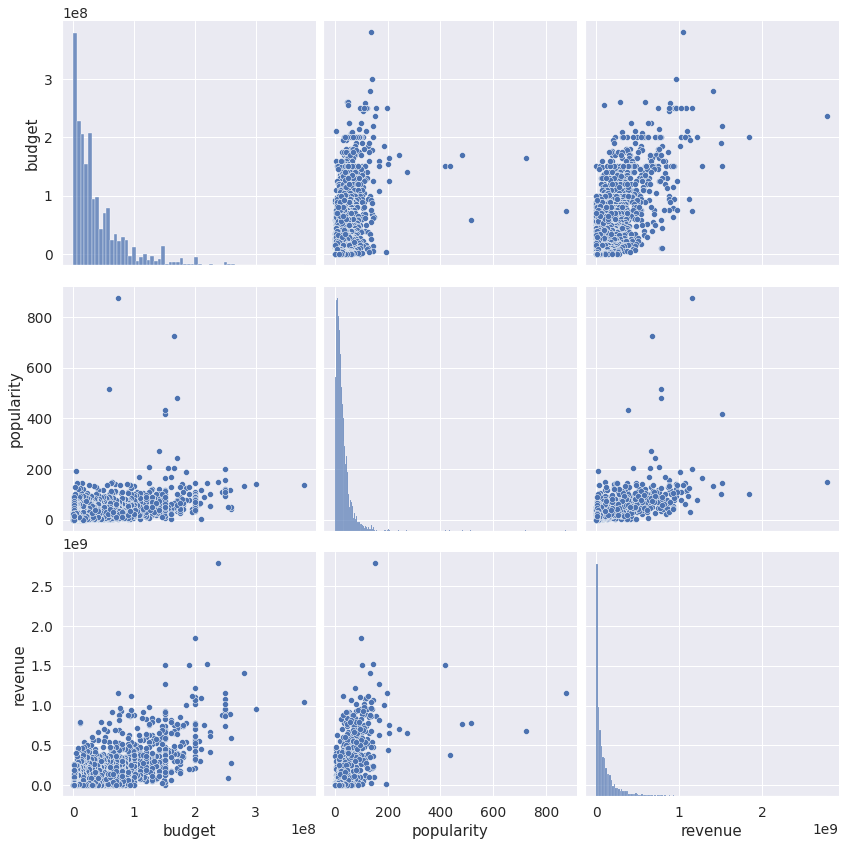

In [ ]:
continuous_covariates = ['budget', 'popularity', 'runtime', 'vote_count', 'vote_average']
outcomes_and_continuous_covariates = continuous_covariates + [regression_target, classification_target]
plotting_variables = ['budget', 'popularity', regression_target]

sns.pairplot(data=df[plotting_variables], height=4)

# determining the skew.
print(df[outcomes_and_continuous_covariates].skew())

* It appears that the variables `budget`, `popularity`, `runtime`, `vote_count`, and `revenue` are all right-skewed.
* Only `vote_average` and `profitable` are the data with negative value and all the others contain positive or right skewdness.

### Feature Transformation

Here, we will transform these variables to eliminate this skewness. Specifically, we will use the `np.log10()` method. Because some of these variable values are exactly 0, we will add a small positive value to each to ensure it is defined; this is necessary because log(0) is negative infinity.

#### Steps
- For each above-mentioned variable in the dataset `df`, we will transform the value `x` into `np.log10(1+x)`.

In [ ]:
# Eliminating skewness for each Variable
for covariate in ['budget', 'popularity', 'runtime', 'vote_count', 'revenue']:
    df[covariate] = df[covariate].apply(lambda x: np.log10(1+x))

budget         -3.117974
popularity     -0.325490
runtime        -4.081196
vote_count     -0.451869
vote_average   -0.707662
revenue        -2.164551
profitable     -0.842966
dtype: float64


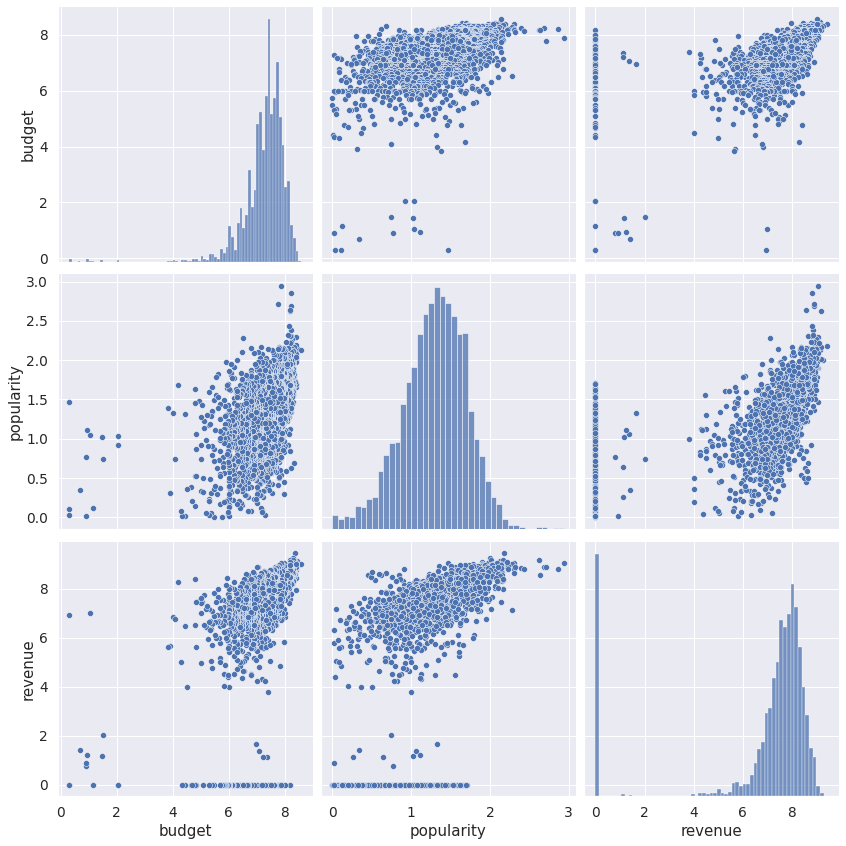

In [ ]:
sns.pairplot(data=df[plotting_variables], height=4)

print(df[outcomes_and_continuous_covariates].skew())

* We see now that the skewness has been eliminated
* All the variables are having negative value.

### Storing the transformed dataset

We will now save our dataset. 

#### Steps
- We use `to_csv()` to save the `df` object as `movies_clean.csv`.

In [ ]:
# Enter your code here
df.to_csv("movies_clean.csv")

# Part 2: Exploratory Data Analysis

### We will **analyse** the important segments of the dataset and try to gain **valuable insights** from it

In [ ]:
# Reading the cleaned dataset
df2 = pd.read_csv("movies_clean.csv", index_col=0)
df2.head()

,budget,genres,id,keywords,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,movie_id,cast,profitable,return,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie,year
0,8.374748,"Action, Adventure, Fantasy, Science Fiction",19995,"culture clash, future, space war, space colony...",en,"In the 22nd century, a paraplegic Marine is di...",2.180234,2009-12-10,9.445287,2.212188,Released,Enter the World of Pandora.,Avatar,7.2,4.071919,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",1,11.763566,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2009
1,8.477121,"Adventure, Fantasy, Action",285,"ocean, drug abuse, exotic island, east india t...",en,"Captain Barbossa, long believed to be dead, ha...",2.146384,2007-05-19,8.982723,2.230449,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,3.653309,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S...",1,3.203333,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2007
2,8.389166,"Action, Adventure, Crime",206647,"spy, based on novel, secret agent, sequel, mi6...",en,A cryptic message from Bond’s past sends him o...,2.034936,2015-10-26,8.944815,2.173186,Released,A Plan No One Escapes,Spectre,6.3,3.650016,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra...",1,3.594590,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2015
3,8.397940,"Action, Crime, Drama, Thriller",49026,"dc comics, crime fighter, terrorist, secret id...",en,Following the death of District Attorney Harve...,2.054280,2012-07-16,9.035405,2.220108,Released,The Legend Ends,The Dark Knight Rises,7.6,3.959375,49026,"Christian Bale, Michael Caine, Gary Oldman, An...",1,4.339756,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2012
4,8.414973,"Action, Adventure, Science Fiction",49529,"based on novel, mars, medallion, space travel,...",en,"John Carter is a war-weary, former military ca...",1.652507,2012-03-07,8.453531,2.123852,Released,"Lost in our world, found in another.",John Carter,6.1,3.327359,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ...",1,1.092843,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012


### Statistical Analysis

In [ ]:
# Analysing all the features from a statistical point of view
df2.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id,profitable,return,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie,year
count,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3.266000e+03,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000
mean,7.278334,45488.042254,1.292131,6.855850,2.038060,6.271341,2.604175,45488.042254,0.694121,2.919456e+03,0.281384,0.203919,0.106246,0.135334,0.163197,0.443662,0.301286,0.054501,0.110839,0.017453,0.349051,0.176363,0.115738,0.085119,0.040416,0.033068,0.034293,0.009186,0.001225,0.000612,2001.765769
std,0.740971,77053.912258,0.405928,2.486905,0.082333,0.894677,0.631083,77053.912258,0.460849,1.497546e+05,0.449743,0.402971,0.308200,0.342132,0.369602,0.496892,0.458887,0.227038,0.313981,0.130970,0.476743,0.381187,0.319959,0.279102,0.196964,0.178841,0.182008,0.095415,0.034980,0.024742,12.953301
min,0.301030,5.000000,0.000688,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1916.000000
25%,7.000000,5307.500000,1.041590,7.030228,1.986772,5.700000,2.204120,5307.500000,0.000000,7.362006e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1998.000000
50%,7.397940,11317.000000,1.317127,7.695402,2.029384,6.300000,2.645913,11317.000000,1.000000,2.085807e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005.000000
75%,7.740363,44698.250000,1.575985,8.146561,2.082785,6.900000,3.042477,44698.250000,1.000000,4.180151e+00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2010.000000
max,8.579784,417859.000000,2.942792,9.445287,2.530200,8.500000,4.138397,417859.000000,1.000000,8.500000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2016.000000


#### Observations:

* It shows the count of all the features as 3266 confirming that the data present in the dataset is constant and doesn't contain any discrepancy.
* It also shows the mean of all the features and we can clearly see that all the numerical features have been normalized to their log10 counterparts.
* It also shows us the maximum and minimum values present in each feature.

### Correlation Analysis

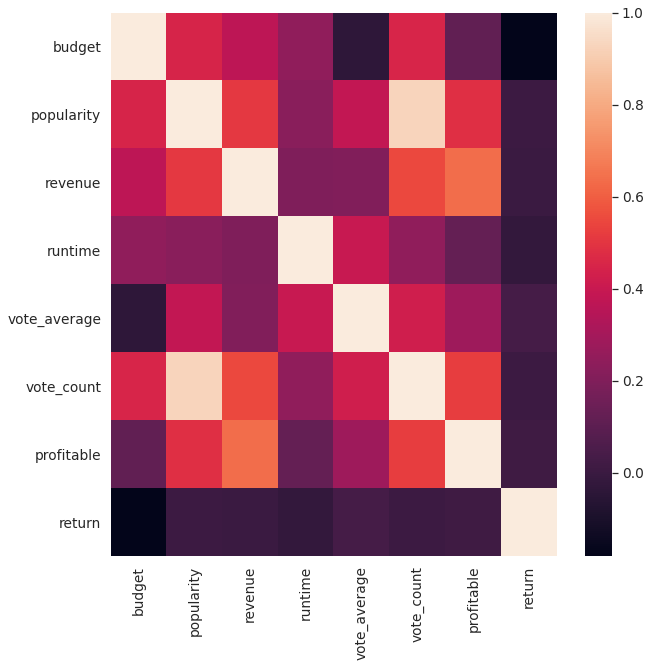

In [ ]:
# Plotting the correlation heatmap of all the features of our dataset
plt.figure(figsize=(10, 10))
sns.heatmap(df2.iloc[:,:19].drop(['id', 'movie_id'], axis=1).corr())

#### Observations:

* Most of the features have Pearson's Correlation Coefficient between 0.3 and 0.7 meaning that they have some relation between them.
* `return` feature is solely created for visualization and so is irrelevant to all the features.

### Regression Target Analysis

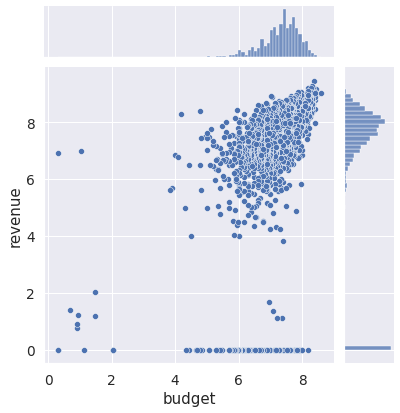

In [ ]:
# plotting the correlation graph between revenue and budget
sns.jointplot(x='budget', y='revenue', data=df2)

#### Observations:
* We can definitely see strong corelation between budget and revenue
* Quite a few number of outliers are present
* The relation is mostly linear

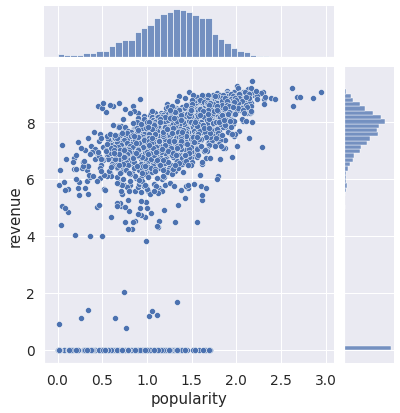

In [ ]:
# plotting the correlation graph between revenue and popularity
sns.jointplot(x='popularity', y='revenue', data=df2)

#### Observations:
* Again as expected, we see some corelation between revenue and popularity
* Here, too, quite a few number of outliers are present
* The relation is mostly linear

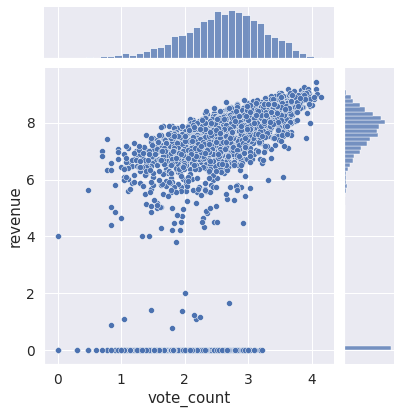

In [ ]:
# plotting the correlation graph between revenue and vote_count
sns.jointplot(x='vote_count', y='revenue', data=df2)

#### Observations:
* Strong corelation between revenue and vote_count is observed. 
* The movies that have good returns are necessary to have a good critical score.
* There are outliers present, although not too many.
* The relation is strongly linear.

#### **This proves that Predicting `revenue` would require Regression model and thus we will be using - "Linear Regression" and "Random Forest Regression"**

### Movie return Trend analysis over the years

In [ ]:
# Sorting out the title, vote_count and year to check the movies with highest vote_counts ever
df2[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10)

,title,vote_count,year
96,Inception,4.138397,2010
65,The Dark Knight,4.079290,2008
0,Avatar,4.071919,2009
16,The Avengers,4.071035,2012
788,Deadpool,4.041235,2016
95,Interstellar,4.036150,2014
287,Django Unchained,4.004321,2012
94,Guardians of the Galaxy,3.988693,2014
426,The Hunger Games,3.975707,2012
127,Mad Max: Fury Road,3.974420,2015


In [ ]:
# Storing the same part of the Dataframe with revenue and return in a variable
most_popular_movies_and_return = df2[['title', 'vote_count', 'year','revenue','return']].sort_values('vote_count', ascending=False)

In [ ]:
np.log10(1000000000)

9.0

In [ ]:
# Storing only the movies with a very high revenue, specifically revenue > 1,00,00,00,000 or 1 billion
most_popular_movies_and_return = most_popular_movies_and_return[most_popular_movies_and_return['revenue']>=9]
most_popular_movies_and_return.head(10)

,title,vote_count,year,revenue,return
65,The Dark Knight,4.079290,2008,9.001975,5.430046
0,Avatar,4.071919,2009,9.445287,11.763566
16,The Avengers,4.071035,2012,9.181717,6.907081
3,The Dark Knight Rises,3.959375,2012,9.035405,4.339756
31,Iron Man 3,3.944828,2013,9.084734,6.077200
28,Jurassic World,3.937668,2015,9.179991,10.090192
98,The Hobbit: An Unexpected Journey,3.918973,2012,9.009070,4.084414
329,The Lord of the Rings: The Return of the King,3.906604,2003,9.048787,11.903074
29,Skyfall,3.881099,2012,9.044760,5.542805
25,Titanic,3.878694,1997,9.266004,9.225171


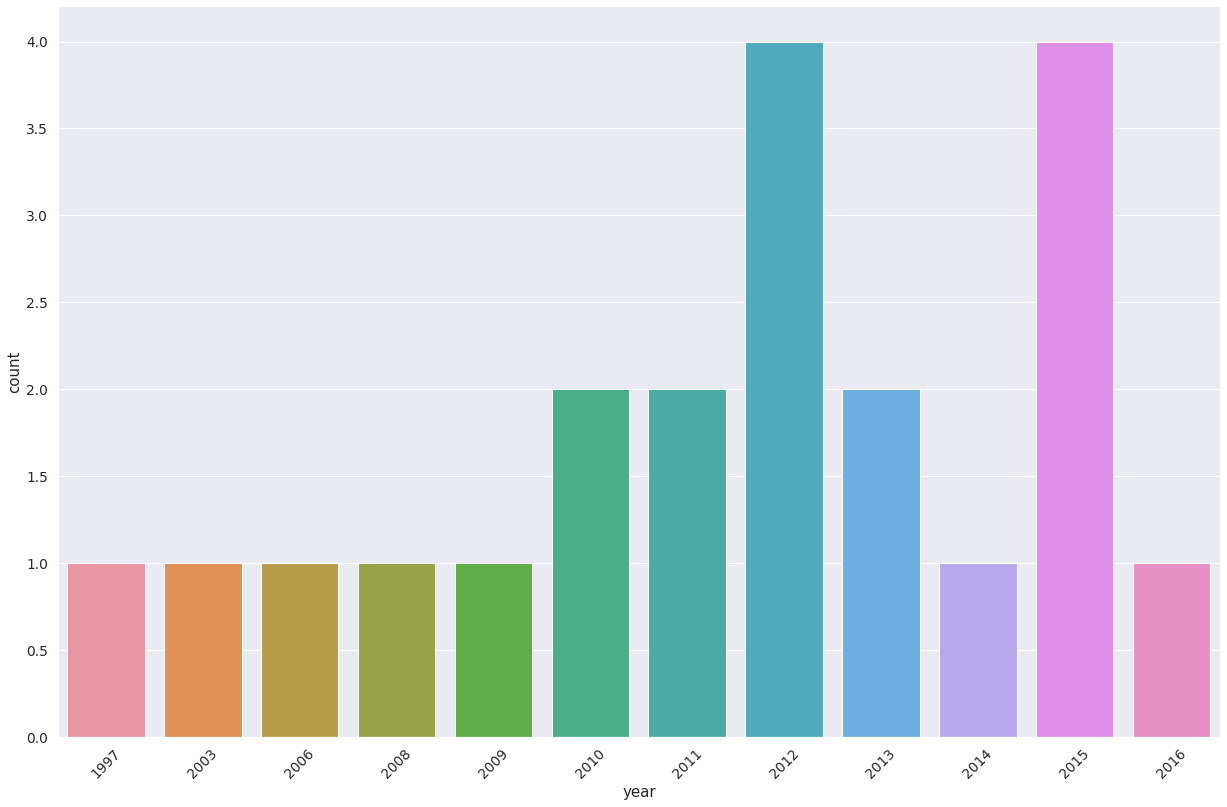

In [ ]:
# Plotting High-revenue and high-vote_count movies according to their release year
chart = sns.catplot(x="year", data=most_popular_movies_and_return, kind="count")
chart.set_xticklabels(rotation=45)

plt.gcf().set_size_inches(20, 12)

#### Observations:

* After Titanic (1997) which was the first movie to reach 1 billion dollar mark, 2010, 2011, 2012, 2013 and 2015 had many movies crossing the billion dollar mark signimficantly.
* There has been an increase in the revenue of movies filmed till 2012 which showed the peak revenue generated, and although it decreased sharply for 2013 and 2014 yet, it again increased in 2015

### Trend Analysis of `vote_average` of movies

In [ ]:
np.log10(3000)

3.4771212547196626

In [ ]:
# Extracting and printing the sorted sub-dataset of title, vote_average, vote_count and year of the movies for which vote_count is greater than 3000
df2[df2['vote_count'] > 3.477][['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head(10)

,title,vote_average,vote_count,year
1881,The Shawshank Redemption,8.5,3.914132,1994
3337,The Godfather,8.4,3.770410,1972
3865,Whiplash,8.3,3.628900,2014
2294,Spirited Away,8.3,3.584444,2001
1818,Schindler's List,8.3,3.636488,1993
3232,Pulp Fiction,8.3,3.925776,1994
662,Fight Club,8.3,3.973774,1999
2731,The Godfather: Part II,8.3,3.523616,1974
809,Forrest Gump,8.2,3.899164,1994
690,The Green Mile,8.2,3.607348,1999


#### Observations:
* These are the 1st 10 movies in rank considering the vote_average feature
* We observe that The Shawshank Redemption (1994) is the movie with the highest vote_average ever

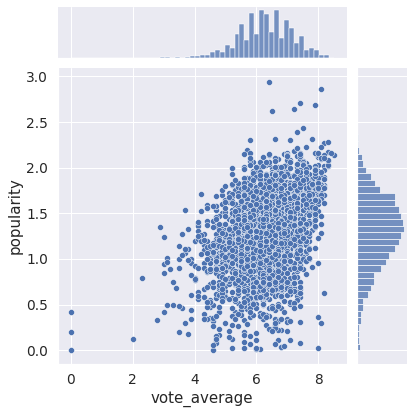

In [ ]:
# plotting the correlation graph between vote_average and popularity
sns.jointplot(x='vote_average', y='popularity', data=df2)

#### Observations:
* Some corelation between vote_average and popularity is observed. 
* The movies that have high vote_average doesn't necessarily have to be highly popular.
* There are outliers present, although not too many.
* The relation is mostly linear.

### Genre feature Analysis

In [ ]:
# Extracting the number of of each genre used throughout the total dataset
Movies = []
for genre in genres:
    Movies.append(df2[genre].value_counts()[1])
Movies

[919,
 666,
 347,
 442,
 533,
 1449,
 984,
 178,
 362,
 57,
 1140,
 576,
 378,
 278,
 132,
 108,
 112,
 30,
 4,
 2]

In [ ]:
pop_gen = pd.DataFrame(Movies, genres).reset_index()
pop_gen

,index,0
0,Action,919
1,Adventure,666
2,Fantasy,347
3,Science Fiction,442
4,Crime,533
5,Drama,1449
6,Thriller,984
7,Animation,178
8,Family,362
9,Western,57


In [ ]:
# Creating a new dataframe to store the genres and their count in a sorted order
pop_gen = pd.DataFrame(Movies, genres).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.sort_values(by='movies', inplace=True, ascending=False, ignore_index=True)
pop_gen

,genre,movies
0,Drama,1449
1,Comedy,1140
2,Thriller,984
3,Action,919
4,Adventure,666
5,Romance,576
6,Crime,533
7,Science Fiction,442
8,Horror,378
9,Family,362


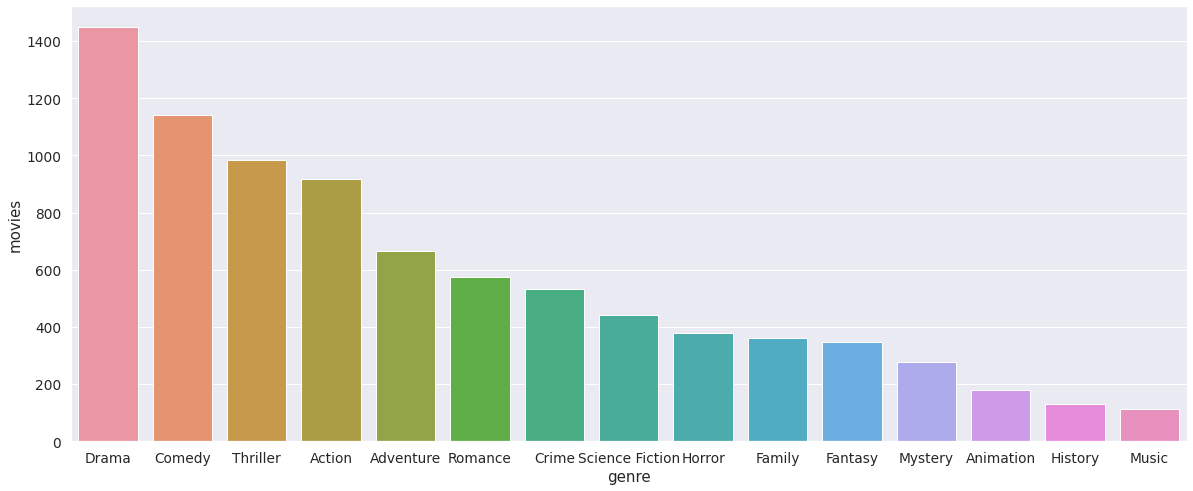

In [ ]:
# Plotting the first 15 genres and their movie count
plt.figure(figsize=(20,8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))

#### Observations:
* Drama is the most used genre in the Film Industry.
* Comdey and Thriller genres follow after it.
* Foreign and TV Movie genres has the lowest movie count (excluded in the graph).

### General Movie Trend Analysis

In [ ]:
# Checking the most expensive movie ever made
df3 = df2[df2['budget'].notnull()][['title', 'budget', 'revenue', 'return', 'year']].sort_values('budget', ascending=False)
df3.head(10)

,title,budget,revenue,return,year
17,Pirates of the Caribbean: On Stranger Tides,8.579784,9.019413,2.751878,2011
1,Pirates of the Caribbean: At World's End,8.477121,8.982723,3.203333,2007
7,Avengers: Age of Ultron,8.447158,9.147801,5.019299,2015
4,John Carter,8.414973,8.453531,1.092843,2012
6,Tangled,8.414973,8.772171,2.276134,2010
5,Spider-Man 3,8.411620,8.949815,3.452991,2007
13,The Lone Ranger,8.406540,7.950802,0.350157,2013
19,The Hobbit: The Battle of the Five Armies,8.397940,8.980467,3.824079,2014
3,The Dark Knight Rises,8.397940,9.035405,4.339756,2012
8,Harry Potter and the Half-Blood Prince,8.397940,8.970328,3.735837,2009


In [ ]:
# Printing the Highest Budget that was expended by "Pirates of the Caribbean: On Stranger Tides"
10 ** df3['budget'].max()

380000000.9999994

#### Observations:
* Pirates of the Caribbean: On Stranger Tides, the Johny Depp starrer is the most expensive movie ever made! The budget was 3.8 Billion which is still the highest!

In [ ]:
# Checking the highest grossing movies of all time
gross_top = df2[['title', 'budget', 'revenue', 'year']].sort_values('revenue', ascending=False).head(10)
gross_top

,title,budget,revenue,year
0,Avatar,8.374748,9.445287,2009
25,Titanic,8.301030,9.266004,1997
16,The Avengers,8.342423,9.181717,2012
28,Jurassic World,8.176091,9.179991,2015
44,Furious 7,8.278754,9.177897,2015
7,Avengers: Age of Ultron,8.447158,9.147801,2015
124,Frozen,8.176091,9.105244,2013
31,Iron Man 3,8.301030,9.084734,2013
546,Minions,7.869232,9.063232,2015
26,Captain America: Civil War,8.397940,9.061944,2016


In [ ]:
10 ** gross_top['revenue'][0]

2787965088.000003

#### Observations: 
* The mighty Avatar was the highest grossing movie of all time, since it generated the highest revenue ever, which was surpassed recently by the Avengers: End Game.

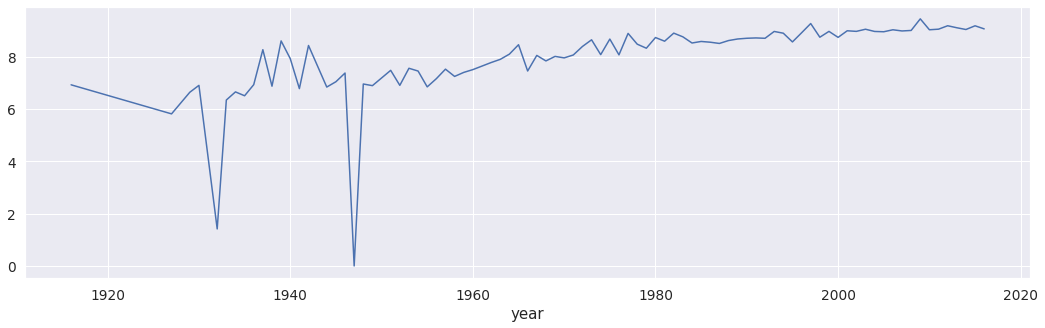

In [ ]:
# Checking the trend of revenue over the years
plt.figure(figsize=(18,5))
year_revenue = df2.groupby('year')['revenue'].max()
year_revenue.plot(kind='line')

#### Observations:
* We can see that the revenue has been steadily increasing over the years 

# Part 3: Predictive and Comparison Modeling

####In Part 3 of this case study, we will primarily use the **two models** we previously discussed: **linear/logistic regression** and **random forests** to perform prediction for **regression** and **classification**. We will use the regression models to **predict revenue**, and we will use classification models to **classify whether a movie was profitable**.

### Defining Variables and Instantiating Predictive Models

In this segment, we will instantiate regression and classification models. Code provided prepares the covariates and outcomes we will use for model analysis.

#### Steps
- Instantiate `LinearRegression()`, `LogisticRegression()`, `RandomForestRegressor()`, and `RandomForestClassifier()` objects, and assign them to `linear_regression`, `logistic_regression`, `forest_regression`, and `forest_classifier`, respectively.
- For the random forests models, specify `max_depth=4` and `random_state=0` initially.

In [ ]:
# Define all covariates and outcomes from `df`.
regression_target = 'revenue'
classification_target = 'profitable'
all_covariates = ['budget', 'popularity', 'runtime', 'vote_count', 'vote_average', 'Action', 'Adventure', 'Fantasy', 
                  'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy', 'Romance', 
                  'Horror', 'Mystery', 'War', 'History', 'Music', 'Documentary', 'TV Movie', 'Foreign']

regression_outcome = df[regression_target]
classification_outcome = df[classification_target]
covariates = df[all_covariates]

# Instantiate all regression models and classifiers.
linear_regression = LinearRegression(fit_intercept=True, normalize=True)
logistic_regression = LogisticRegression(max_iter=1000)
forest_regression = RandomForestRegressor(max_depth=4, random_state=0)
forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)

### Defining Metrics for scoring our Models

In this segment, we will create two functions that compute a model's score. For regression models, we will use correlation as the score. For classification models, we will use accuracy as the score.

#### Steps
- Define a function called `correlation` with arguments `estimator`, `X`, and `y`. The function should compute the correlation between the observed outcome `y` and the outcome predicted by the model.
    - To obtain predictions, the function should first use the `fit` method of `estimator` and then use the `predict` method from the fitted object.
    - The function should return the first argument from `r2_score` comparing `predictions` and `y`.
- Define a function called `accuracy` with the same arguments and code, and computing the `accuracy_score` for comparing `predictions` and `y`.

In [ ]:
def correlation(estimator, X, y):
    predictions = estimator.fit(X, y).predict(X)
    return r2_score(y, predictions)

def accuracy(estimator, X, y):
    predictions = estimator.fit(X, y).predict(X)
    return accuracy_score(y, predictions)

### Performance of Baseline Regression Models

In this segment, we will compute the `cross-validated` performance for the linear and random forest regression models.

#### Steps

- Call `cross_val_score` using `linear_regression` and `forest_regression` as models. Store the output as `linear_regression_scores` and `forest_regression_scores`, respectively.
    - Set the parameters `cv=10` to use 10-fold cross-validation and `scoring=correlation` to use our `correlation` function defined in the previous segment.
- Plotting code has been provided to compare the performance of the two models. Use `plt.show()` to plot the `correlation` between **actual** and **predicted** revenue for each cross-validation fold using the linear and random forest regression models.
- We observe that `forest_regression` clearly shows a better performance than `linear_regression`

Linear Regression Scores: [0.34629263 0.18048078 0.26013231 0.25660351 0.29642796 0.18214009
 0.23756296 0.27476138 0.36637537 0.38254666] 
Forest Regression Scores: [0.82734243 0.58048084 0.53047469 0.5237927  0.61230199 0.47882372
 0.45987321 0.54075802 0.56945885 0.55119326]
Linear Regression Score: 0.2783323656675956 
Forest Regression Scores: 0.567449970190382


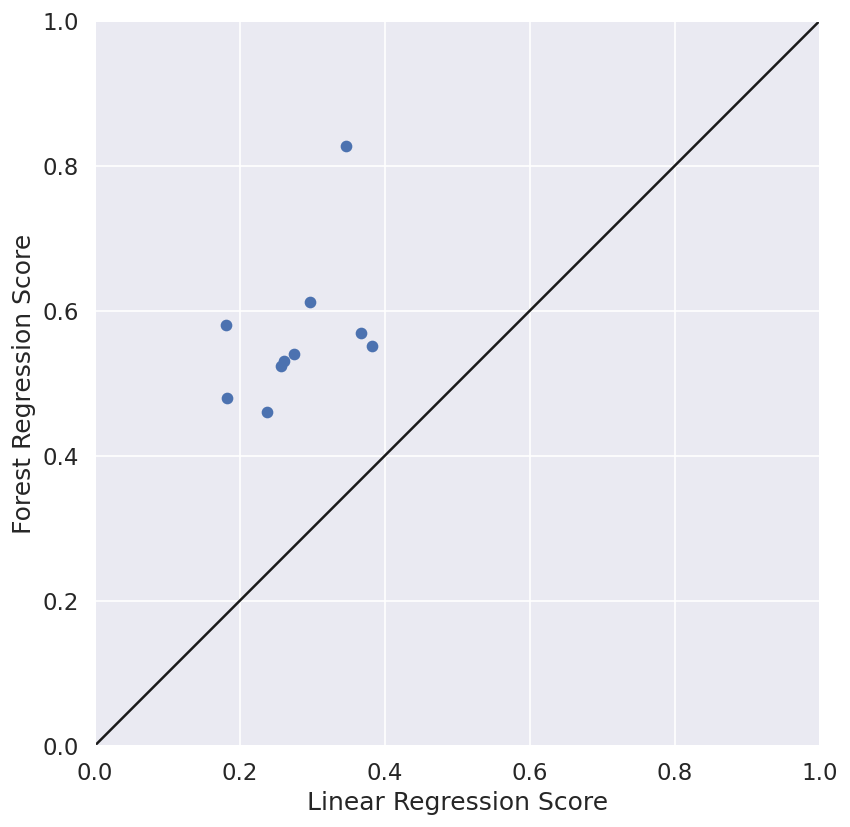

In [ ]:
# Determine the cross-validated correlation for linear and random forest models.
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)
# Plot Results
plt.figure(figsize=(8,8), facecolor='w', dpi=120)
plt.axes().set_aspect('equal', 'box')
plt.scatter(linear_regression_scores, forest_regression_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Regression Score")
plt.ylabel("Forest Regression Score")

# print the scores
print("Linear Regression Scores:", linear_regression_scores, "\nForest Regression Scores:", forest_regression_scores)

# Print the mean scores
print("Linear Regression Score:", np.mean(linear_regression_scores), "\nForest Regression Scores:", np.mean(forest_regression_scores))

# Show the plot.
plt.show()

We observe that 10-fold `cross-validation` of - 
>`forest_regression` scores range from 0.4 to 0.6 and we also have one above 0.8

>`linear_regression` scores range from 0.2 to 0.4

This clearly shows that the baseline model for `forest_regression` works better than that of `linear_regression`

### Performance of Baseline Classification Models

In this segment, we will compute cross-validated performance for the logistic and random forest classification models.

#### Instructions 
- Call `cross_val_score` using `logistic_regression` and `forest_classifier` as models. Store the output as `logistic_regression_scores` and `forest_classification_scores`, respectively.
    - Set the parameters `cv=10` to use 10-fold cross-validation and `scoring=accuracy` to use our accuracy function defined in the previous exercise.
- Plotting code has been provided to compare the performance of the two models. Use `plt.show()` to plot the `accuracy` of predicted `profitability` for each cross-validation fold using the logistic and random forest classification models.
- We observe that both models performs good for the classification but `forest_classifier` works a bit better.

Logistic Regression Scores: [0.91131498 0.85626911 0.89602446 0.87461774 0.84097859 0.83792049
 0.84355828 0.82822086 0.80981595 0.80368098] 
Forest Classification Scores: [0.95412844 0.95412844 0.97859327 0.96330275 0.92966361 0.91743119
 0.96625767 0.92331288 0.88957055 0.84969325]
Logistic Regression Score: 0.8502401455882629 
Forest Classification Scores: 0.9326082062250238


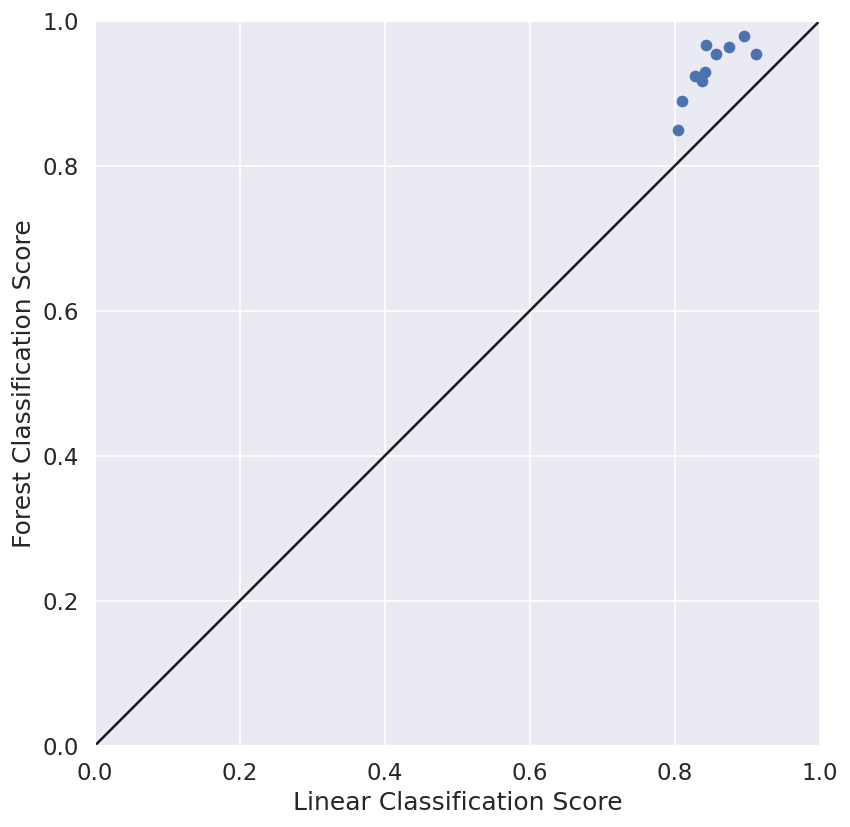

In [ ]:
# Determine the cross-validated accuracy for logistic and random forest models.
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)
# Plot Results
plt.figure(figsize=(8,8), facecolor='w', dpi=120)
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")

# print the scores
print("Logistic Regression Scores:", logistic_regression_scores, "\nForest Classification Scores:", forest_classification_scores)

# Print the mean scores
print("Logistic Regression Score:", np.mean(logistic_regression_scores), "\nForest Classification Scores:", np.mean(forest_classification_scores))

# Show the plot.
plt.show()

We observe that 10-fold `cross-validation` of - 
> `forest_classification` scores range mainly from 0.9 to 1

> `logistic_regression` scores range from 0.8 to 0.9

This clearly shows that `forest_classification` works a bit better than `logistic_regression`

### Improving Performance of Predictive Models 

In the Baseline Regression and Classification Models, we saw that predicting `revenue` was only moderately successful while predicting `profitablity` was really successful. It might be the case that predicting movies that generated precisely no revenue is difficult. In the next three segments, we will exclude these movies, and rerun the analyses to determine if the fits **improve**. In this segment, we will rerun the regression analysis for this subsetted dataset.
Although our target is to improve the regression models, we will still re-train our classification models too for an even better prediction than before.

#### Steps

- Define `positive_revenue_df` as the subset of movies in `df` with `revenue` greater than zero.
- Code is provided below that creates new instances of model objects. Change the `max_depth` parameter of `RandomForest` models from $4$ to $20$ to increase the accuracy of our model. Replace all instances of `df` with `positive_revenue_df`.

In [ ]:
positive_revenue_df = df[df.revenue > 0]

# Replace the dataframe in the following code.

regression_outcome = positive_revenue_df[regression_target]
classification_outcome = positive_revenue_df[classification_target]
covariates = positive_revenue_df[all_covariates]

# Reinstantiate all regression models and classifiers changing the "max_depth" parameter of our RandomForest Regressor and Classifier.
linear_regression = LinearRegression(fit_intercept=True, normalize=True)
logistic_regression = LogisticRegression(max_iter=1000)
forest_regression = RandomForestRegressor(max_depth=20, random_state=0)
forest_classifier = RandomForestClassifier(max_depth=20, random_state=0)

### Performance of Optimized Regression Models

In this segment, we will compute the cross-validated performance for the optimized linear and random forest regression models for positive revenue movies only.

#### Steps

- Call `cross_val_score` using `linear_regression` and `forest_regression` as models. Store the output as `linear_regression_scores` and `forest_regression_scores`, respectively.
    - Set the parameters `cv=10` to use 10-fold cross-validation and `scoring=correlation` to use our `correlation` function defined in the previous exercise.
- Plotting code has been provided to compare the performance of the two models. Use `plt.show()` to plot the correlation between **actual** and **predicted** revenue for each cross-validation fold using the optimized linear and random forest regression models.
- Here, too, the `forest_regression` model works better than the `linear_regression` model. We also find substantial improvement in the performance of our regression models.
- Code is provided that prints the importance of each covariate in predicting revenue using the random forests regresssor. 
    - We observe that `vote_count`, `budget` and `popularity` are the most important features in **predicting revenue** 

Linear Regression Scores: [0.69499467 0.65469345 0.55611339 0.53935215 0.5282503  0.49612886
 0.46010822 0.40262575 0.59526262 0.34963542] 
Forest Regression Scores: [0.94248728 0.94417169 0.91656935 0.91537018 0.90063549 0.88887538
 0.8927123  0.90383198 0.93086626 0.87472553]
Linear Regression Score: 0.5277164831925378 
Forest Regression Scores: 0.9110245442435104


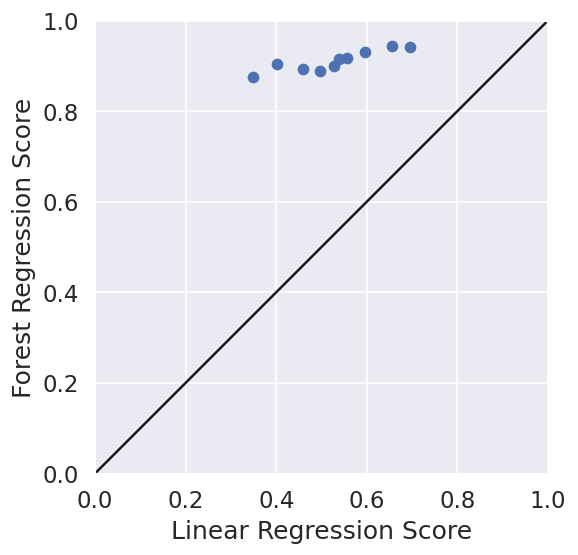

[('TV Movie', 0.0),
 ('Foreign', 0.00019451886848061625),
 ('Documentary', 0.000770247495060919),
 ('History', 0.0011983868642010062),
 ('Western', 0.001681682600822341),
 ('Animation', 0.002328943152840267),
 ('Music', 0.0029286077957537933),
 ('War', 0.003358498137479063),
 ('Family', 0.0036447881691100453),
 ('Fantasy', 0.0040724246396627835),
 ('Horror', 0.004317475627051731),
 ('Adventure', 0.004332978392311065),
 ('Romance', 0.004526072905643128),
 ('Mystery', 0.004562997619417912),
 ('Action', 0.005457830935637969),
 ('Comedy', 0.005971708468969015),
 ('Crime', 0.006154015801259207),
 ('Science Fiction', 0.0062509706471508865),
 ('Thriller', 0.007793558727763475),
 ('Drama', 0.008296379636712207),
 ('vote_average', 0.053015556866495034),
 ('runtime', 0.05777698041422592),
 ('popularity', 0.08364158834413118),
 ('budget', 0.293240442597374),
 ('vote_count', 0.43448334529244653)]

In [ ]:
# Determine the cross-validated correlation for linear and random forest models.
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)

# Plot Results
plt.figure(figsize=(5,5), facecolor='w', dpi=120)
plt.axes().set_aspect('equal', 'box')
plt.scatter(linear_regression_scores, forest_regression_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Regression Score")
plt.ylabel("Forest Regression Score")

# print the scores
print("Linear Regression Scores:", linear_regression_scores, "\nForest Regression Scores:", forest_regression_scores)

# Print the mean scores
print("Linear Regression Score:", np.mean(linear_regression_scores), "\nForest Regression Scores:", np.mean(forest_regression_scores))

# Show the plot.
plt.show()

# Print the importance of each covariate in the random forest regression.
forest_regression.fit(covariates, regression_outcome)    
sorted(list(zip(all_covariates, forest_regression.feature_importances_)), key=lambda tup: tup[1])

We observe that the 10-fold Cross-Validation of - 
> Optimized `forest_regressor` score for positive revenue data range around 0.9

> `linear_regression` score for positive evenue data range from 0.4 to 0.7 which is quite good for a linear model

### Performance of Optimized Classification Model

In this segment, we will compute cross-validated performance for the logistic and random forest classification models for positive revenue movies only.

#### Steps 

- Call `cross_val_score` using `logistic_regression` and `forest classifer` as models. Store the output as `logistic_regression_scores` and `forest_classification_scores`, respectively.
    - Set the parameters `cv=10` to use 10-fold cross-validation and `scoring=accuracy` to use our `accuracy` function defined in the previous segment.
- Plotting code has been provided to compare the performance of the two models. Use `plt.show()` to plot the accuracy between actual and predicted profitability for each cross-validation fold using the logistic and random forest classification models.
- `forest classifer` obviously performs far better than `logistic_regression`. In fact, `logistic_regression` doesn't improve at all and is stuck at the same range but `forest classifer` improves to a perfection.
- Code is provided that prints the importance of each covariate in predicting profitabilitiy using the random forests classifier. 
    - We observe that here too `vote_count`, `popularity` and `budget` are the most important features but the importance of `popularity` and `budget` are reversed

Logistic Regression Scores: [0.9112628  0.86986301 0.85273973 0.85958904 0.8390411  0.8390411
 0.8630137  0.85273973 0.81164384 0.80479452] 
Forest Classification Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Logistic Regression Score: 0.8503728552059471 
Forest Classification Scores: 1.0


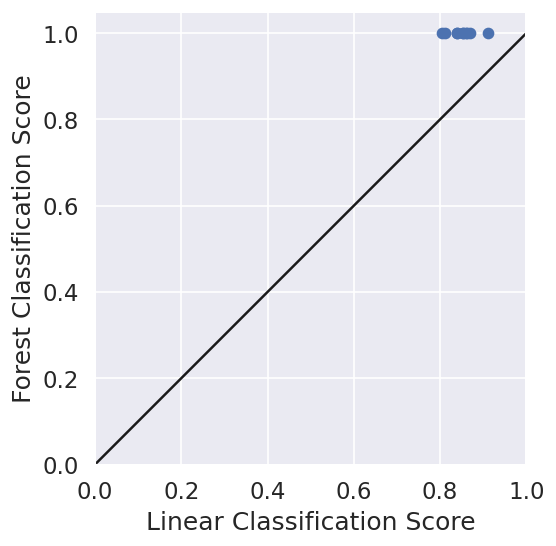

[('TV Movie', 0.0),
 ('Foreign', 0.0012059174628992477),
 ('Documentary', 0.0027305137496895344),
 ('Western', 0.004559226052851061),
 ('Animation', 0.004858198501389),
 ('History', 0.005601369717735389),
 ('War', 0.0057642920441868875),
 ('Music', 0.007386140216607966),
 ('Family', 0.008097415264685132),
 ('Fantasy', 0.009862527517590976),
 ('Mystery', 0.010696849389787795),
 ('Horror', 0.010938245161745167),
 ('Science Fiction', 0.013412525247202637),
 ('Romance', 0.013419507444560573),
 ('Crime', 0.014542753565998472),
 ('Adventure', 0.015379001961693171),
 ('Thriller', 0.01643039787495597),
 ('Comedy', 0.016755810462346803),
 ('Drama', 0.018388985555067017),
 ('Action', 0.01897045011846339),
 ('runtime', 0.1094396711390282),
 ('vote_average', 0.11933623760775135),
 ('budget', 0.1418917784764939),
 ('popularity', 0.2027104310016824),
 ('vote_count', 0.22762175446558794)]

In [ ]:
# Determine the cross-validated accuracy for logistic and random forest models.
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

# Plot Results
plt.figure(figsize=(5,5), facecolor='w', dpi=120)
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1.05) # increasing the limit a bit for proper visualization 
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")

# print the scores
print("Logistic Regression Scores:", logistic_regression_scores, "\nForest Classification Scores:", forest_classification_scores)

# Print the mean scores
print("Logistic Regression Score:", np.mean(logistic_regression_scores), "\nForest Classification Scores:", np.mean(forest_classification_scores))

# Show the plot.
plt.show()

# Print the importance of each covariate in the random forest classification.
forest_classifier.fit(covariates, classification_outcome)
sorted(list(zip(all_covariates, forest_classifier.feature_importances_)), key=lambda tup: tup[1])

We observe that the 10-fold Cross-Validation of - 
> Optimized `forest_classifier` scores for positive revenue data are all perfect and classifies the profitability with **100% accuracy**.

> `logistic_regression` scores for positive revenue data are still the same as it was during the baseline models, i.e., they range from 0.8 to 0.9 and didn't improve at all.